# Casper Neo. MPCS 52010 Computer Architecture.

In [1]:
import os
import subprocess
import re
import matplotlib.pyplot as plt

In [2]:
DEBUG = False
INSTRUCTION_COLOR = "green"
READ_COLOR ='blue'
WRITE_COLOR = 'red'
HIT_LINE_STYLE = '-'
MISS_LINE_STYLE = ':'
EMULATOR_PATH = "./target/release/cache_emulator"

In [3]:
def get_stats(flags):
  """Returns the stats from the cache emulator"""
  command = EMULATOR_PATH
  for x in flags:
    # use one or two dashes if its a long or short flag argument
    command += f" -{x}" if len(x) == 1 else f" --{x}"
    command += f" {flags[x]}"
  if DEBUG: print(command)
  raw = subprocess.check_output(command.split(' ')).decode("utf-8")
  results = {}
  for stat in ("read hits", "read misses", "write hits", "write misses", "instruction count"):
    x = re.findall(r"{}\t[0-9]+".format(stat), raw)[0]
    x = x.replace(stat,'')
    results[stat] = int(x)

  return results

In [4]:
def plot_stats(results, xs, ax):
  """Plots the 5 cache statistics"""
  for stat in ("read hits", "read misses", "write hits", "write misses", "instruction count"):
    c = READ_COLOR if 'read' in stat else WRITE_COLOR
    ls = HIT_LINE_STYLE if 'hits' in stat else MISS_LINE_STYLE
    ys = [r[stat] for r in results]
    if DEBUG: print(f"{stat}: {ys}")
    if stat == "instruction count":
      ax.plot(xs,ys, color=INSTRUCTION_COLOR)
    else:
      ax.plot(xs, ys, color=c, linestyle=ls, label=stat)

  return ax

In [5]:
def vary(name, vs, flags={}, xlog=2, ylog=False, ax=None):
  """Varys continuous flag variable `name` over values `vs` then plots the statistics"""
  res = []
  for v in vs:
    this_flags = flags.copy()
    this_flags[name] = v
    res.append(get_stats(this_flags))
    
  if not ax:
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel(name)
  ax.legend()

  plot_stats(res, vs, ax)
  ax.set_title(f"{flags}" if flags else "")
  if xlog: ax.set_xscale('log', basex=xlog)
  if ylog: ax.set_yscale('log')

In [6]:
def go(name, xs, figsize=(15,15), xlog=2, ylog=True):
  """Analysis grid. Varys `name` for each algorithm and replacement policy."""
  fig, ax = plt.subplots(nrows=3,ncols=3, figsize=figsize)
  
  for i, algorithm in enumerate(["dot", "mxm", "mxm-block"]):
    for j, replacement in enumerate(["FIFO","random","LRU"]):
      vary(name, xs, {"a":algorithm, "r":replacement}, xlog, ylog, ax[i][j])

  ax[2][1].set_xlabel(name)
  plt.show()

# ANALYSIS

In this analysis I compare `cache-size`, `block-size` and `associativity` against the three algorithms and three replacement policies. Unless specified, they are set to the default values as per the prompt.
I use a default test size of 500 * 500 matricies for the matrix algorithms. My cache emulator squares uses vectors with lengths equal to the square of `test-size` for the `dot` algorithm so the data scales quadratically. This way we may have more fair comparisions with the matrix multiply algorithms.
The default `test-size` has 500,000 doubles or 400,000 bytes which is larger than the default cache size of 65,536 bytes by a factor of 61x

## Cache Size

* `mxm-block` has far more cache hits than `mxm` for larger cache sizes.
* In `LRU`, `mxm` and `mxm-block` are much more to cache size
* `random` is a surprisingly consistent replacement policy and somehow seems to better than FIFO
* As expected, in general, larger cache sizes leads to lower miss rates.

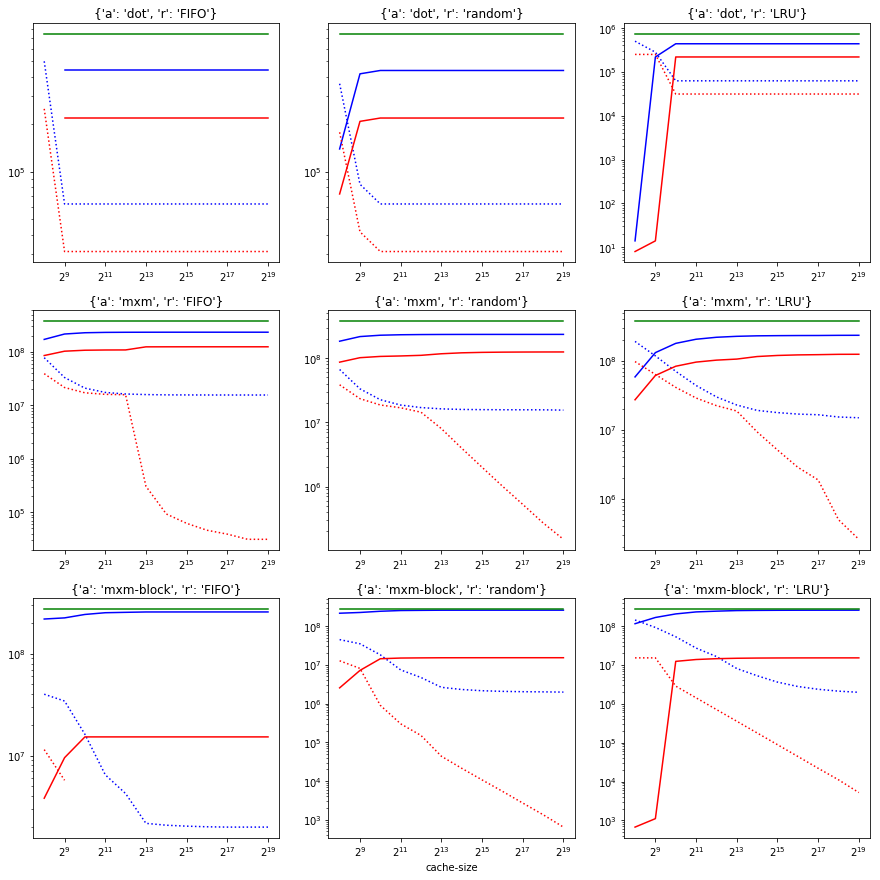

In [7]:
go("cache-size", [2**x for x in range(8,20)])

## Test Size
* For the dot product, the statistics grow with as expected with the test size.
* For the matrix algorithms the miss behavior seems more complicated.
* `mxm-block` has fewer write misses for small matricies - even zero
    * That's because we load `cij` then `aik` and `bik` for a bunch of `k` before storing `cij` again
    * The write misses are therefore capacity misses
    * The FIFO policy works great for `mxm-block`

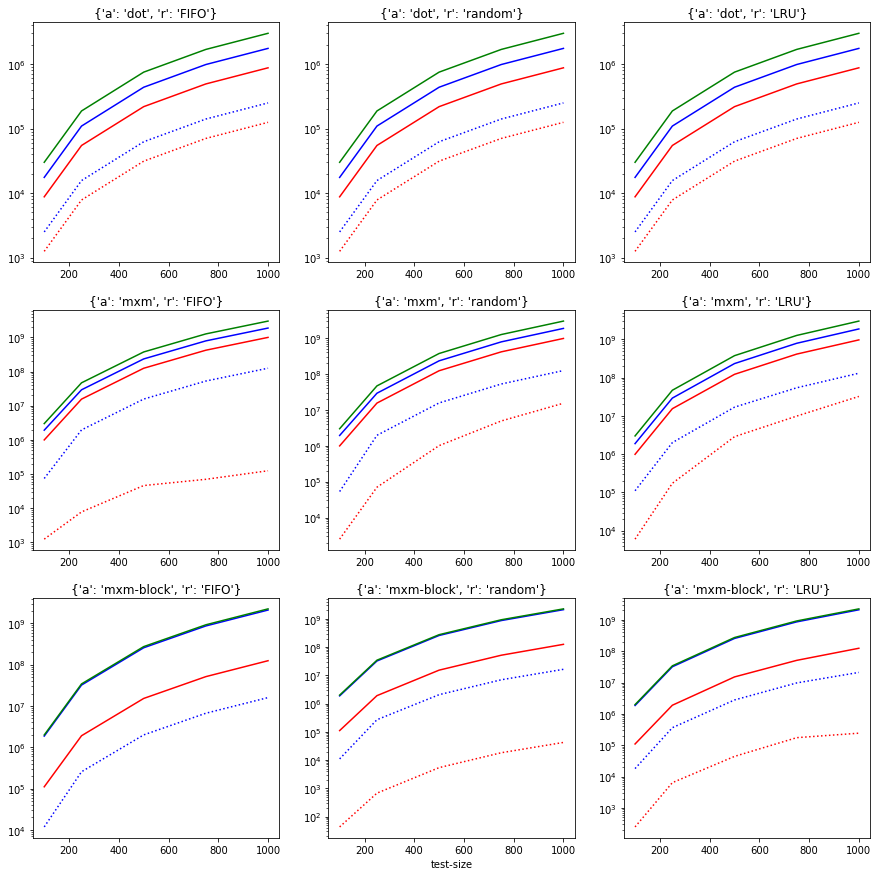

In [7]:
go("test-size",[100, 250, 500, 750, 1000],xlog=0)

## Associativity
* Fun fact, with associativity 2 and test size 4096, the dot product's two loads and one write share an index leading to no read nor write hits due to conflict misses.
* Associativity seems to have no effect on the dot product since the CPU just passes straight through.
* Except for the `LRU` policy...
* More associativity seems to negatively affect the matrix multiply algorithms for LRU cache
    * This could be because the `cik` are first loaded then kept in registers for a while before being written
    * While its kept in registers, the cache throws away the corresponding cache line since it hasn't been used
    * Low associativity protects this from happening to the `cik` line.

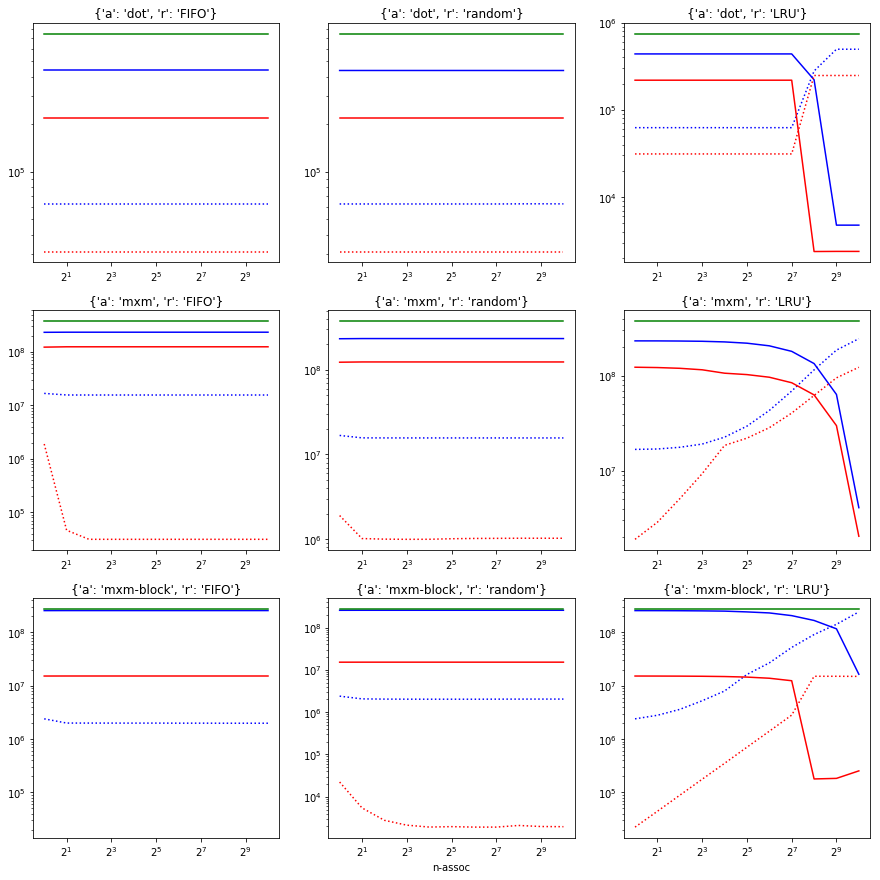

In [7]:
go("n-assoc", [2**x for x in range(11)])


## Block sizes
* For all policies larger block sizes make the dot product have fewer misses
     * That's obvious since we're just iterating continuously through 3 places in memory
* The same analysis applies to `mxm` with `FIFO` and random
* With an `LRU` policy, its weirder since `mxm` revisits blocks a lot. There seems to be an optimum
* `mxm-block` also seems to be affected similarly.

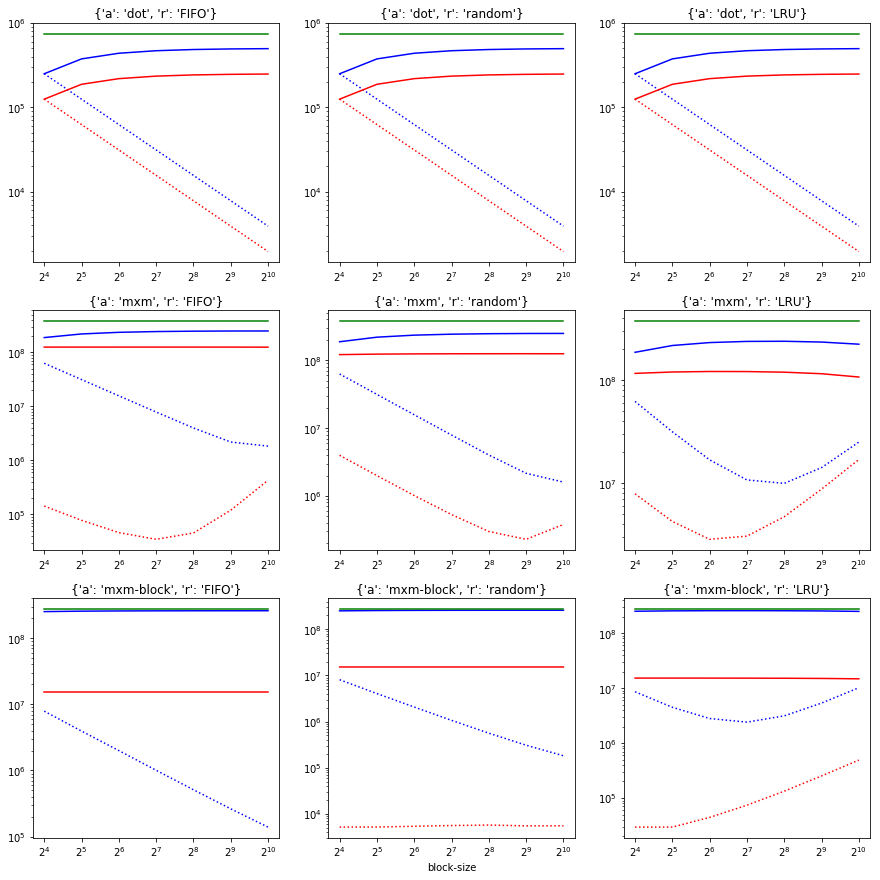

In [ ]:
go("block-size", [2**i for i in range(4, 11)])